In [1]:
train_dir = r"C:\Users\rafci\Desktop\tensorflow-speech-recognition-challenge\train"

In [2]:
import librosa
import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from data_preparation import make_spec
torch.random.manual_seed(4)
x = make_spec("yes/bfdb9801_nohash_0.wav", train_dir)+1.3
#torch.random.manual_seed(8)

time_masking = T.TimeMasking(time_mask_param=40)
freq_masking = T.FrequencyMasking(freq_mask_param=40)

time_masked = time_masking(torch.Tensor(x)).numpy()
freq_masked = freq_masking(torch.Tensor(x)).numpy()
# Assuming 'freq_masked' is your final spectrogram after transformations
# spectrogram = freq_masked





c:\Users\rafci\Desktop\transformers\data_preparation.py:44: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(sig[:16000],


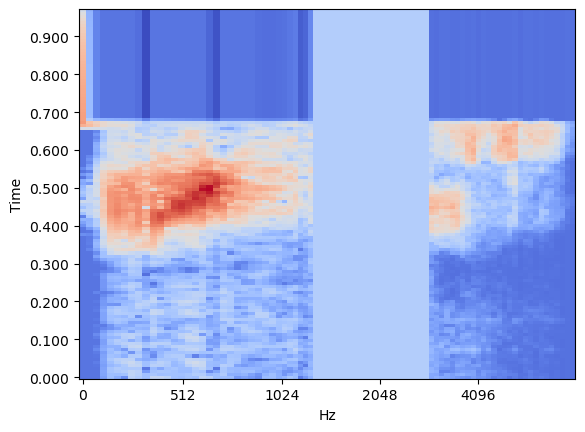

In [3]:
librosa.display.specshow(time_masked,
                         x_axis="mel",
                         fmax=8000,
                         y_axis="time",
                         sr=16000,
                         hop_length=128)

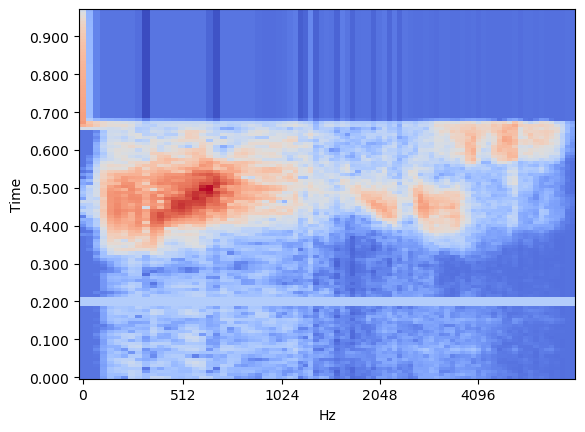

In [4]:
librosa.display.specshow(freq_masked,
                         x_axis="mel",
                         fmax=8000,
                         y_axis="time",
                         sr=16000,
                         hop_length=128)

In [5]:
import numpy as np
import os

In [6]:
X_train = np.load("data/X_train.npy")
y_train = np.load("data/y_train.npy")



X_val = np.load("data/X_val.npy")
y_val = np.load("data/y_val.npy")

X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2]))



X_val = X_val.reshape((-1, X_val.shape[1], X_val.shape[2]))

classes = os.listdir(train_dir+'/audio/')
NB_CLASSES = len(classes)
classes

def convert_list_dict(lst):
    res_dct = {i: val for i, val in enumerate(lst)}
    return res_dct
         
classes_index = convert_list_dict(classes)
classes_index

{0: 'bed',
 1: 'bird',
 2: 'cat',
 3: 'dog',
 4: 'down',
 5: 'eight',
 6: 'five',
 7: 'four',
 8: 'go',
 9: 'happy',
 10: 'house',
 11: 'left',
 12: 'marvin',
 13: 'nine',
 14: 'no',
 15: 'off',
 16: 'on',
 17: 'one',
 18: 'right',
 19: 'seven',
 20: 'sheila',
 21: 'silence',
 22: 'six',
 23: 'stop',
 24: 'three',
 25: 'tree',
 26: 'two',
 27: 'up',
 28: 'wow',
 29: 'yes',
 30: 'zero'}

In [7]:
import torch.nn.functional as F

import torch

y_train = torch.tensor(y_train).long()
y_val = torch.tensor(y_val).long()
X_train = torch.tensor(X_train)

X_train_masked = freq_masking(X_train)
X_train_masked =time_masking(X_train_masked)

X_val = torch.tensor(X_val)



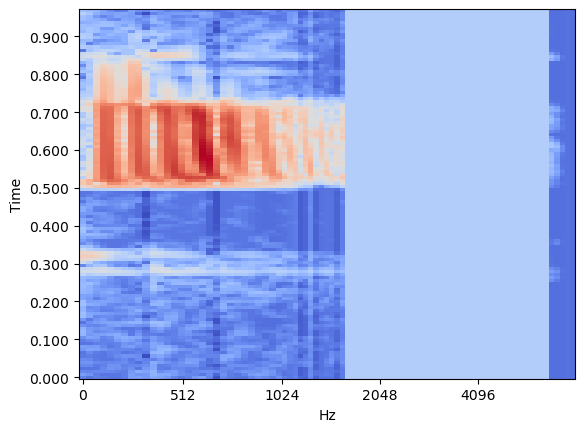

In [8]:
librosa.display.specshow(X_train_masked[0].numpy(),
                         x_axis="mel",
                         fmax=8000,
                         y_axis="time",
                         sr=16000,
                         hop_length=128)

In [9]:
y_train = F.one_hot(y_train, num_classes=NB_CLASSES)
# y_val = F.one_hot(y_val, num_classes=NB_CLASSES)
print(y_val[:10])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [10]:
from keras.layers import Conv1D, MaxPool1D, Concatenate, BatchNormalization, Activation, Input, Add, \
                         GlobalAveragePooling1D, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKeras
from tensorflow.keras.metrics import Recall, Precision
import keras
import time

In [11]:
def f1_score(y_true, y_pred):
    y_pred = y_pred.round().clamp(0, 1)
    y_true = y_true.round().clamp(0, 1)

    true_positives = (y_true * y_pred).sum()
    possible_positives = y_true.sum()
    predicted_positives = y_pred.sum()

    precision = true_positives / (predicted_positives + 1e-7)
    recall = true_positives / (possible_positives + 1e-7)

    f1_val = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1_val

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
import numpy as np
import time

from models.Inception import InceptionClassifier


In [13]:
INPUT_SHAPE = (85, 122)
print(X_train.shape)
BATCH_SIZE = 64
nb_epochs=10

torch.Size([58284, 122, 85])


In [47]:
torch.random.manual_seed(4)

# Model, criterion, optimizer
model = InceptionClassifier(INPUT_SHAPE, NB_CLASSES).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

# Data loaders
train_dataset = TensorDataset(X_train.float().transpose(2, 1).to('cuda'), y_train.float().to('cuda'))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(X_val.float().transpose(2, 1).to('cuda'), y_val.float().to('cuda'))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training loop
for epoch in range(nb_epochs):
    model.train()
    for inputs, labels in train_loader:
        
        inputs = freq_masking(inputs)
        inputs = time_masking(inputs)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            # _, labels = torch.max(labels, 1)
            
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        
        accuracy = total_correct / total_samples
        print(f'Epoch [{epoch+1}/{nb_epochs}], Validation Accuracy: {accuracy:.4f}')

print("Training finished.")

Epoch [1/10], Validation Accuracy: 0.4799
Epoch [2/10], Validation Accuracy: 0.7326
Epoch [3/10], Validation Accuracy: 0.7815
Epoch [4/10], Validation Accuracy: 0.8688
Epoch [5/10], Validation Accuracy: 0.8766
Epoch [6/10], Validation Accuracy: 0.8836
Epoch [7/10], Validation Accuracy: 0.8997
Epoch [8/10], Validation Accuracy: 0.9032
Epoch [9/10], Validation Accuracy: 0.9133
Epoch [10/10], Validation Accuracy: 0.9164
Training finished.


In [14]:
# Model, criterion, optimizer
model = InceptionClassifier(INPUT_SHAPE, NB_CLASSES).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)

# Data loaders
train_dataset = TensorDataset(X_train.float().transpose(2, 1).to('cuda'), y_train.float().to('cuda'))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(X_val.float().transpose(2, 1).to('cuda'), y_val.float().to('cuda'))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training loop
for epoch in range(nb_epochs):
    model.train()
    for inputs, labels in train_loader:
        
        inputs = freq_masking(inputs)
        inputs = time_masking(inputs)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            # _, labels = torch.max(labels, 1)
            
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        
        accuracy = total_correct / total_samples
        print(f'Epoch [{epoch+1}/{nb_epochs}], Validation Accuracy: {accuracy:.4f}')

print("Training finished.")

c:\Users\rafci\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\rafci\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\rafci\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  ret

Epoch [1/10], Validation Accuracy: 0.6017
Epoch [2/10], Validation Accuracy: 0.7962
Epoch [3/10], Validation Accuracy: 0.8415
Epoch [4/10], Validation Accuracy: 0.8642
Epoch [5/10], Validation Accuracy: 0.8937
Epoch [6/10], Validation Accuracy: 0.8915
Epoch [7/10], Validation Accuracy: 0.9184
Epoch [8/10], Validation Accuracy: 0.9164
Epoch [9/10], Validation Accuracy: 0.9346
Epoch [10/10], Validation Accuracy: 0.9251
Training finished.


In [15]:
torch.save(model.state_dict(), 'models/inception_aug.pth')

In [17]:
model = InceptionClassifier(INPUT_SHAPE, NB_CLASSES).to('cuda')
model.load_state_dict(torch.load('models/inception_aug.pth'))
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        # _, labels = torch.max(labels, 1)
        
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{nb_epochs}], Validation Accuracy: {accuracy:.4f}')

Epoch [10/10], Validation Accuracy: 0.9251
